# Scheduler

In [1]:
LLAMA_HYPER_CONFIG = dict(
    beta1=0.9,
    beta2=0.95,
    adam_eps=1e-5,
    warmup_steps=20,
    lr_decay_perc=0.1,
    weight_decay=0.1,
    gradient_clipping=1,
    lr=3e-4,
)

In [6]:
import torch.optim.lr_scheduler as lr_scheduler
import bitsandbytes as bnb
import torch

In [17]:
model = torch.nn.Linear(10,10)
trainable_params = model.parameters()
llama_lr = LLAMA_HYPER_CONFIG["lr"]
llama_lr_perc = LLAMA_HYPER_CONFIG["lr_decay_perc"]
optimizer = bnb.optim.PagedAdamW(
    trainable_params,
    lr=LLAMA_HYPER_CONFIG["lr"],
    weight_decay=LLAMA_HYPER_CONFIG["weight_decay"],
    betas=(LLAMA_HYPER_CONFIG["beta1"], LLAMA_HYPER_CONFIG["beta2"]),
    eps=LLAMA_HYPER_CONFIG["adam_eps"],
)
scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=100, eta_min=llama_lr * llama_lr_perc
)

In [18]:
lrs = []
for i in range(200):
    scheduler.step()
    
    for param_group in optimizer.param_groups:
        lrs.append(param_group["lr"])


/opt/conda/envs/Parrot/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


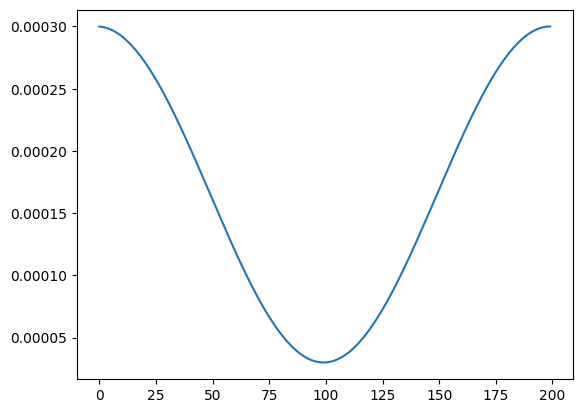

In [19]:
import matplotlib.pyplot as plt
plt.plot(lrs)

## Try Generation

In [1]:
import json
import sys
import time
import warnings
from pathlib import Path
from typing import Literal, Optional

import lightning as L
import torch
from lightning.fabric.strategies import FSDPStrategy


from generate.base import generate
from lit_gpt import Tokenizer
from lit_gpt.lora import GPT, Block, Config, merge_lora_weights
from lit_gpt.utils import check_valid_checkpoint_dir, get_default_supported_precision, lazy_load, quantization
from scripts.prepare_alpaca import generate_prompt

lora_r = 8
lora_alpha = 16
lora_dropout = 0.05
lora_query = True
lora_key = True
lora_value = True
lora_projection = True
lora_mlp = True
lora_head = True

/opt/conda/envs/Parrot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prompt: str = "How many heads of the departments are older than 56 ?"
instruction = prompt
input: str = "CREATE TABLE head (age INTEGER)"
lora_path: Path = Path("out/lora/sql_llama_2/lit_model_lora_finetuned.pth")
checkpoint_dir: Path = Path("checkpoints/meta-llama/Llama-2-7b-hf/")
quantize = "bnb.nf4"
max_new_tokens: int = 100
top_k: int = 200
temperature: float = 0.1
strategy: str = "auto"
devices: int = 1
precision: Optional[str] = None

In [3]:
precision = precision or get_default_supported_precision(training=False)

if strategy == "fsdp":
    strategy = FSDPStrategy(auto_wrap_policy={Block}, cpu_offload=False)
fabric = L.Fabric(devices=devices, precision=precision, strategy=strategy)
fabric.launch()

check_valid_checkpoint_dir(checkpoint_dir)

with open(checkpoint_dir / "lit_config.json") as fp:
    config_params = dict(
        r=lora_r,
        alpha=lora_alpha,
        dropout=lora_dropout,
        to_query=lora_query,
        to_key=lora_key,
        to_value=lora_value,
        to_projection=lora_projection,
        to_mlp=lora_mlp,
        to_head=lora_head,
    )
    config_params.update(**json.load(fp))
    config = Config(**config_params)

if quantize is not None and devices > 1:
    raise NotImplementedError
if quantize == "gptq.int4":
    model_file = "lit_model_gptq.4bit.pth"
    if not (checkpoint_dir / model_file).is_file():
        raise ValueError("Please run `python quantize/gptq.py` first")
else:
    model_file = "lit_model.pth"
checkpoint_path = checkpoint_dir / model_file

You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [4]:

fabric.print(f"Loading model {str(checkpoint_path)!r} with {config.__dict__}", file=sys.stderr)
t0 = time.perf_counter()
with fabric.init_module(empty_init=True), quantization(quantize):
    model = GPT(config)
fabric.print(f"Time to instantiate model: {time.perf_counter() - t0:.02f} seconds.", file=sys.stderr)

Loading model 'checkpoints/meta-llama/Llama-2-7b-hf/lit_model.pth' with {'org': 'meta-llama', 'name': 'Llama-2-7b-hf', 'block_size': 4096, 'vocab_size': 32000, 'padding_multiple': 64, 'padded_vocab_size': 32000, 'n_layer': 32, 'n_head': 32, 'n_embd': 4096, 'rotary_percentage': 1.0, 'parallel_residual': False, 'bias': False, 'n_query_groups': 32, 'shared_attention_norm': False, '_norm_class': 'RMSNorm', 'norm_eps': 1e-05, '_mlp_class': 'LLaMAMLP', 'intermediate_size': 11008, 'condense_ratio': 1, 'r': 8, 'alpha': 16, 'dropout': 0.05, 'to_query': True, 'to_key': True, 'to_value': True, 'to_projection': True, 'to_mlp': True, 'to_head': True}
Time to instantiate model: 5.75 seconds.


In [5]:
t0 = time.perf_counter()
with lazy_load(checkpoint_path) as checkpoint, lazy_load(lora_path) as lora_checkpoint:
    checkpoint.update(lora_checkpoint.get("model", lora_checkpoint))
    model.load_state_dict(checkpoint, strict=quantize is None)
fabric.print(f"Time to load the model weights: {time.perf_counter() - t0:.02f} seconds.", file=sys.stderr)

Time to load the model weights: 6.01 seconds.


In [6]:
model.eval()
merge_lora_weights(model)
model = fabric.setup(model)



/opt/conda/envs/Parrot/lib/python3.10/site-packages/lightning/fabric/fabric.py:943: PossibleUserWarning: The model passed to `Fabric.setup()` has 66 parameters on different devices (for example 'transformer.wte.weight' on cuda:0 and 'lm_head.lora_A' on cpu). Since `move_to_device=True`, all parameters will be moved to the new device. If this is not desired, set `Fabric.setup(..., move_to_device=False)`.
  rank_zero_warn(


In [7]:
tokenizer = Tokenizer(checkpoint_dir)
sample = {"instruction": instruction, "input": input}
prompt = generate_prompt(sample)
encoded = tokenizer.encode(prompt, device=model.device)
prompt_length = encoded.size(0)
max_returned_tokens = prompt_length + max_new_tokens

In [10]:
prompt

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nHow many heads of the departments are older than 56 ?\n\n### Input:\nCREATE TABLE head (age INTEGER)\n\n### Response:'

In [11]:
t0 = time.perf_counter()
y = generate(
    model,
    encoded,
    max_returned_tokens,
    max_seq_length=max_returned_tokens,
    temperature=temperature,
    top_k=top_k,
    eos_id=tokenizer.eos_id,
)
t = time.perf_counter() - t0

model.reset_cache()
output = tokenizer.decode(y)
output_orig = output
output = output.split("### Response:")[1].strip()
fabric.print(output)

tokens_generated = y.size(0) - prompt_length
fabric.print(f"\n\nTime for inference: {t:.02f} sec total, {tokens_generated / t:.02f} tokens/sec", file=sys.stderr)
if fabric.device.type == "cuda":
    fabric.print(f"Memory used: {torch.cuda.max_memory_allocated() / 1e9:.02f} GB", file=sys.stderr)

MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:




Time for inference: 3.52 sec total, 28.39 tokens/sec
Memory used: 4.70 GB


In [13]:
output

'MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:MS:'

## Try Finetune

In [1]:
import json
import sys
from pathlib import Path

import requests
import torch
from torch.utils.data import random_split
from tqdm import tqdm

from datasets import load_dataset


from lit_gpt.tokenizer import Tokenizer

/opt/conda/envs/Parrot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
def prepare_sample(
    example: dict,
    tokenizer: Tokenizer,
    max_length: int,
    mask_inputs: bool = MASK_INPUTS,
    ignore_index: int = IGNORE_INDEX,
):
    """Processes a single sample.

    Each sample in the dataset consists of:
    - instruction: A string describing the task
    - input: A string holding a special input value for the instruction.
        This only applies to some samples, and in others this is empty.
    - output: The response string

    This function processes this data to produce a prompt text and a label for
    supervised training. The prompt text is formed as a single message including both
    the instruction and the input. The label/target is the same message but with the
    response attached.

    Finally, both the prompt and the label get tokenized. If desired, all tokens
    in the label that correspond to the original input prompt get masked out (default).
    """
    full_prompt = generate_prompt(example)
    full_prompt_and_response = full_prompt + example["output"]
    encoded_full_prompt = tokenizer.encode(full_prompt, max_length=max_length)
    encoded_full_prompt_and_response = tokenizer.encode(full_prompt_and_response, eos=True, max_length=max_length)

    # The labels are the full prompt with response, but with the prompt masked out
    labels = encoded_full_prompt_and_response.clone()
    if mask_inputs:
        labels[: len(encoded_full_prompt)] = ignore_index

    return {
        **example,
        "input_ids": encoded_full_prompt_and_response,
        "input_ids_no_response": encoded_full_prompt,
        "labels": labels,
    }

def generate_prompt(example):
    """Generates a standardized message to prompt the model with an instruction, optional input and a
    'response' field."""

    if example["input"]:
        return (
            "Below is an instruction that describes a task, paired with an input that provides further context. "
            "Write a response that appropriately completes the request.\n\n"
            f"### Instruction:\n{example['instruction']}\n\n### Input:\n{example['input']}\n\n### Response:"
        )
    return (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        f"### Instruction:\n{example['instruction']}\n\n### Response:"
    )


In [24]:
DATA_FILE_URL = ""
DATA_FILE_NAME = "sql-create-context.json"
DESTINATION_PATH = Path("data/sql-create-context")
CHECKPOINT_DIR = Path("checkpoints/meta-llama/Llama-2-7b-hf/")
TEST_SPLIT_FRACTION = 0.10  
IGNORE_INDEX = -1
MASK_INPUTS = False  # as in alpaca-lora
HUGGING_FACE_DATASET_PATH = "b-mc2/sql-create-context"
SEED = 42

In [29]:
def prepare(
    destination_path: Path = DESTINATION_PATH,
    checkpoint_dir: Path = CHECKPOINT_DIR,
    test_split_fraction: float = TEST_SPLIT_FRACTION,
    seed: int = SEED,
    mask_inputs: bool = MASK_INPUTS,
    data_file_name: str = DATA_FILE_NAME,
    data_file_url: str = DATA_FILE_URL,
    ignore_index: int = IGNORE_INDEX,
) -> None:
    """Prepare the SQL dataset for instruction tuning.

    The output is a training and test dataset saved as `train.pt` and `test.pt`,
    which stores the preprocessed and tokenized prompts and labels.
    """
    with open(checkpoint_dir / "lit_config.json", "r") as file:
        config = json.load(file)
        max_seq_length = config["block_size"]
    print("Loading data file...")
    # this sql dataset has only a train set
    sql_dataset = load_dataset(HUGGING_FACE_DATASET_PATH)["train"]
    sql_dataset = sql_dataset.rename_column("question", "instruction")
    sql_dataset = sql_dataset.rename_column("context", "input")
    sql_dataset = sql_dataset.rename_column("answer", "output")
    
    destination_path.mkdir(parents=True, exist_ok=True)
    data_file_path = destination_path / data_file_name
    
    # download_if_missing(data_file_path, data_file_url)
    # with open(data_file_path, "r", encoding="utf-8") as file:
    #     data = json.load(file)

    print("Loading tokenizer...")
    tokenizer = Tokenizer(checkpoint_dir)

    # Partition the dataset into train and test
    train_set, test_set = random_split(
        sql_dataset, [1.0 - test_split_fraction, test_split_fraction], generator=torch.Generator().manual_seed(seed)
    )
    train_set, test_set = list(train_set), list(test_set)

    print(f"train has {len(train_set):,} samples")
    print(f"test has {len(test_set):,} samples")
    print("Processing train split ...")
    train_set = [
        prepare_sample(
            example=sample,
            tokenizer=tokenizer,
            max_length=max_seq_length,
            mask_inputs=mask_inputs,
            ignore_index=ignore_index,
        )
        for sample in tqdm(train_set)
    ]
    torch.save(train_set, destination_path / "train.pt")
    print("Processing test split ...")
    test_set = [
        prepare_sample(
            example=sample,
            tokenizer=tokenizer,
            max_length=max_seq_length,
            mask_inputs=mask_inputs,
            ignore_index=ignore_index,
        )
        for sample in tqdm(test_set)
    ]
    torch.save(test_set, destination_path / "test.pt")
    return train_set, test_set


In [30]:
a = prepare()

Loading data file...


Found cached dataset json (/home/ubuntu/.cache/huggingface/datasets/b-mc2___json/b-mc2--sql-create-context-d62c31544f758e00/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 542.39it/s]


Loading tokenizer...
train has 70,720 samples
test has 7,857 samples
Processing train split ...


100%|██████████| 70720/70720 [00:35<00:00, 2004.06it/s]


Processing test split ...


100%|██████████| 7857/7857 [00:04<00:00, 1844.97it/s]


In [36]:
a[0][0].keys()

dict_keys(['instruction', 'input', 'output', 'input_ids', 'input_ids_no_response', 'labels'])

In [40]:
a[0][3]["input_ids"]

tensor([13866,   338,   385, 15278,   393, 16612,   263,  3414, 29892,  3300,
         2859,   411,   385,  1881,   393,  8128,  4340,  3030, 29889, 14350,
          263,  2933,   393,  7128,  2486,  1614,  2167,   278,  2009, 29889,
           13,    13,  2277, 29937,  2799,  4080, 29901,    13,  5618,   471,
          278,  2407,   363,   278,  3748,   373,  4779, 29871, 29906, 29945,
        29973,    13,    13,  2277, 29937, 10567, 29901,    13, 27045, 10911,
         1591, 29918,   978, 29918, 29906, 29955,   313, 11651, 21748, 29892,
         2635, 21748, 29897,    13,    13,  2277, 29937, 13291, 29901,  6404,
         2407,  3895,  1591, 29918,   978, 29918, 29906, 29955,  5754,  2635,
          353,   376, 29885,  1279, 29871, 29906, 29945, 29908,     2],
       dtype=torch.int32)

In [47]:
tokenizer = Tokenizer(CHECKPOINT_DIR)
encoded = tokenizer.encode("ziopera mamma mia", bos=True, eos=True)

In [48]:
encoded

tensor([    1,   503, 21260,  1572,   286,  2735,   286,   423,     2],
       dtype=torch.int32)

In [49]:
tokenizer.decode(encoded)

'ziopera mamma mia'